### ライブラリ

In [22]:
import os
import torch
from tqdm import tqdm
from metrics import region_consistency_metric
from torch.utils.data import DataLoader
from mylib.data_io import TensorDataset

import matplotlib.pyplot as plt
import numpy as np

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

### 設定

In [23]:
# 画像サイズ
H = 128 
W = 128 
C = 3 

RESTART_MODE = False
DEVICE = 'cuda:0'
USE_AMP = True
FLOAT_DTYPE = torch.float16 
BATCH_SIZE = 100


# データセット
DATA_DIR = './Datasets/'
TEST_INPUT_IMAGES_FILE   = 'defacto_test_input_images.pt'
TEST_TARGET_IMAGES_FILE  = 'defacto_test_target_images.pt'


# 学習結果の保存先フォルダ
MODEL_DIR = './defacto_models/'
MODEL_FILE = os.path.join(MODEL_DIR, 'forgery_detector_model.pth')

### データセット

In [24]:
# テンソルファイルを読み込み, 訓練データセットを用意
if RESTART_MODE:
    test_dataset = TensorDataset(filenames=[
        os.path.join('./temp/', TEST_INPUT_IMAGES_FILE),
        os.path.join('./temp/', TEST_TARGET_IMAGES_FILE)
    ])
else:
    test_dataset = TensorDataset(filenames=[
        os.path.join(DATA_DIR, TEST_INPUT_IMAGES_FILE),
        os.path.join(DATA_DIR, TEST_TARGET_IMAGES_FILE)
    ])
test_size = len(test_dataset)
print(f'Test dataset size: {test_size}')

# テストデータをミニバッチに分けて使用するための「データローダ」を用意
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

Test dataset size: 970


### モデル評価

1. UnetPlusPlus from scratch <br>
dice_loss - 0.4996, iou_score - 0.3349, fscore - 0.5005, accuracy - 0.88, precision - 0.5457, recall - 0.4642

2. UnetPlusPlus with customized loss <br>
dice_loss - 0.1647, iou_score - 0.718, fscore - 0.8354, accuracy - 0.9037, precision - 0.8766, recall - 0.799

3. UnetPlusPlus with pretrained efficientnet-b4 <br>
dice_loss - 0.1647, iou_score - 0.718, fscore - 0.8354, accuracy - 0.9037, precision - 0.8766, recall - 0.799

In [33]:
MODEL_FILE = os.path.join(MODEL_DIR, 'UnetPlusPlus_model.pth')
best_model = torch.load(MODEL_FILE, weights_only=False)
best_model.eval()

loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
    utils.metrics.Fscore(threshold=0.5),
    utils.metrics.Accuracy(threshold=0.5),
    utils.metrics.Precision(threshold=0.5),
    utils.metrics.Recall(threshold=0.5),
]

test_epoch = utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, dice_loss - 0.1647, iou_score - 0.718, fscore - 0.8354, accuracy - 0.9037, precision - 0.8766, recall - 0.799] 


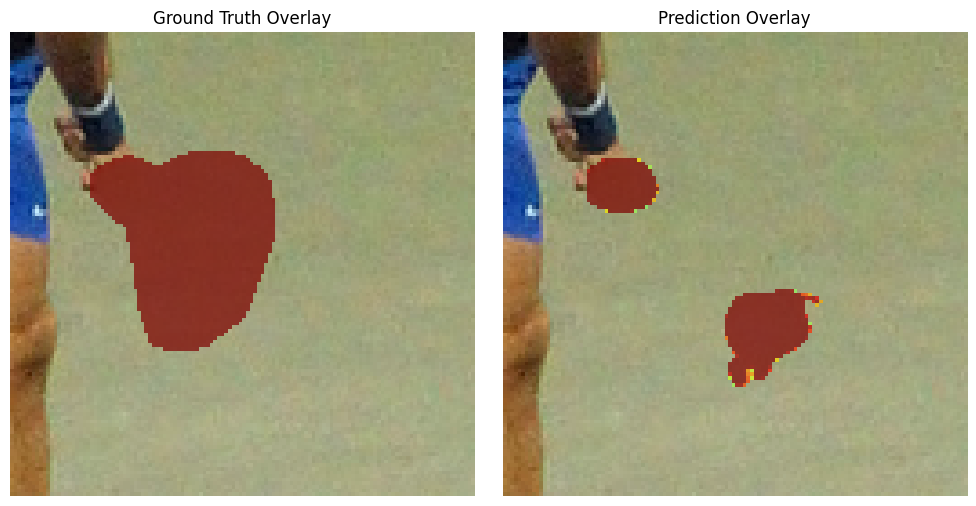

Sample #0 IoU Score: 0.1144
True Positive: 1.70%, False Positive: 2.69%, False Negative: 10.45%
Precision: 0.3872, Recall: 0.1397
--------------------------------------------------


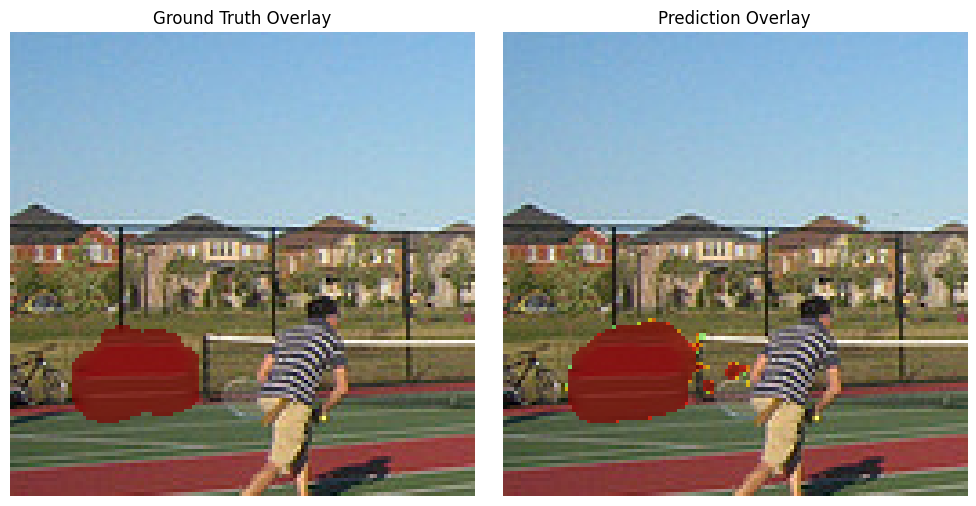

Sample #1 IoU Score: 0.8290
True Positive: 4.47%, False Positive: 0.79%, False Negative: 0.13%
Precision: 0.8492, Recall: 0.9721
--------------------------------------------------


In [34]:
def visualize_mask_overlay(model, dataloader, sample_idx=0, device='cuda:0'):
    model.eval()
    
    # サンプルデータを取得
    inputs, targets = next(iter(dataloader))
    input_img = inputs[sample_idx:sample_idx+1].to(device)
    target_mask = targets[sample_idx:sample_idx+1].to(device)
    
    # 予測を実行
    with torch.no_grad():
        prediction = model(input_img)
    
    # 入力画像の準備
    img = input_img[0].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    
    # マスクを取得
    pred_mask = prediction[0, 0].cpu().numpy()
    true_mask = target_mask[0, 0].cpu().numpy()
    
    # 二値化マスク（統計情報計算用）
    pred_mask_binary = (pred_mask > 0.5).astype(np.float32)
    true_mask_binary = (true_mask > 0.5).astype(np.float32)
    
    # IoUの計算
    intersection = np.logical_and(pred_mask_binary, true_mask_binary).sum()
    union = np.logical_or(pred_mask_binary, true_mask_binary).sum()
    iou = intersection / union if union > 0 else 0
    
    # 面積の計算
    total_pixels = pred_mask.shape[0] * pred_mask.shape[1]
    tp = np.logical_and(pred_mask_binary == 1, true_mask_binary == 1).sum()
    fp = np.logical_and(pred_mask_binary == 1, true_mask_binary == 0).sum()
    fn = np.logical_and(pred_mask_binary == 0, true_mask_binary == 1).sum()
    
    tp_area = tp / total_pixels * 100  # 真陽性の面積 (%)
    fp_area = fp / total_pixels * 100  # 偽陽性の面積 (%)
    fn_area = fn / total_pixels * 100  # 偽陰性の面積 (%)
    
    # 可視化（1x2のサブプロット - 入力画像+正解マスク、入力画像+予測マスク）
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # 正解マスクをオーバーレイ
    axes[0].imshow(img)
    mask = np.ma.masked_where(true_mask < 0.5, true_mask)
    axes[0].imshow(mask, cmap='jet', alpha=0.7, vmin=0, vmax=1)
    axes[0].set_title('Ground Truth Overlay')
    axes[0].axis('off')
    
    # 予測マスクをオーバーレイ
    axes[1].imshow(img)
    mask = np.ma.masked_where(pred_mask < 0.5, pred_mask)
    axes[1].imshow(mask, cmap='jet', alpha=0.7, vmin=0, vmax=1)
    axes[1].set_title('Prediction Overlay')
    axes[1].axis('off')
    
    plt.savefig(f'overlay_sample_{sample_idx}.png', bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()
    
    # コンソールに統計情報を出力
    print(f"Sample #{sample_idx} IoU Score: {iou:.4f}")
    print(f"True Positive: {tp_area:.2f}%, False Positive: {fp_area:.2f}%, False Negative: {fn_area:.2f}%")
    print(f"Precision: {tp/(tp+fp):.4f}, Recall: {tp/(tp+fn):.4f}")
    print("-" * 50)

# サンプルインデックス1と3の画像を表示
visualize_mask_overlay(best_model, test_dataloader, sample_idx=0, device=DEVICE)
visualize_mask_overlay(best_model, test_dataloader, sample_idx=1, device=DEVICE)